In [236]:
import torch
import numpy as np
import pandas as pd
from torch.autograd import Variable
import torch.nn.functional as F
from sklearn.preprocessing import LabelBinarizer, LabelEncoder
import os
import matplotlib.pyplot as plt

os.listdir('../input/')

['data.csv']

In [237]:
data = pd.read_csv('../input/data.csv')
data.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


In [238]:
from sklearn.preprocessing import StandardScaler
def get_features_and_target_arrays(input_df):
    y = input_df['diagnosis']
    x = input_df.drop(['diagnosis'], axis=1)
    scaler = StandardScaler()
    x_scaled = pd.DataFrame(scaler.fit_transform(x), columns=x.columns, index=x.index)
    return x_scaled, y

In [239]:
cols = data.columns
data.drop(['Unnamed: 32'], axis=1, inplace=True)
data.drop(['id'], axis=1, inplace=True)
data = data.dropna()
# x_data = data[cols[2:-1]]
print(len(cols))
# x_data.head()
data['diagnosis'] = data['diagnosis'].map({'M': 1, 'B': 0})
# print(data)
from sklearn.model_selection import train_test_split
random_seed = 888
data_train, data_rest = train_test_split(data, test_size=0.4, random_state=random_seed, stratify=data['diagnosis'])
data_test, data_validate = train_test_split(data_rest, test_size=0.5, random_state=random_seed, stratify=data_rest['diagnosis']) 


33


In [240]:
from sklearn.preprocessing import StandardScaler
def get_features_and_target_arrays(input_df):
    y = input_df['diagnosis']
    x = input_df.drop(['diagnosis'], axis=1)
    scaler = StandardScaler()
    x_scaled = pd.DataFrame(scaler.fit_transform(x), columns=x.columns, index=x.index)
    return x_scaled, y

In [241]:
# print(data_train)
X_train, y_train = get_features_and_target_arrays(data_train)
X_test, y_test = get_features_and_target_arrays(data_test)
X_validate, y_validate = get_features_and_target_arrays(data_validate)
y_train=y_train.to_frame()
y_test=y_test.to_frame()
y_validate=y_validate.to_frame()

# print(type(X_train))
# print(type(X_train.values))
# print(type(y_train))
# print(type(y_test))
# print(type(y_train.values))

In [242]:
y_data = data[cols[1]]
le = LabelEncoder()
y_data = np.array(le.fit_transform(y_data))
y_data[:5], le.classes_


(array([1, 1, 1, 1, 1]), array([0, 1]))

In [243]:
print(type(y_train))
print(type(y_train.values))
x_data = Variable(torch.from_numpy(X_train.values))
y_data = Variable(torch.from_numpy(y_train.values))


X_validate = Variable(torch.from_numpy(X_validate.values))
y_validate = Variable(torch.from_numpy(y_validate.values))
print(type(y_validate))
print(type(X_validate))

<class 'pandas.core.frame.DataFrame'>
<class 'numpy.ndarray'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>


In [244]:
# y_data = data[cols[1]]
# le = LabelEncoder()
# y_data = np.array(le.fit_transform(y_data))
# y_data[:5], le.classes_

In [245]:
# print(type(x_data))
# print(type(y_data))
# print(x_data)

In [246]:
y_data.shape, x_data.numpy().shape


(torch.Size([341, 1]), (341, 30))

In [247]:
# x_data = Variable(torch.from_numpy(x_data.values))
# y_data = Variable(torch.from_numpy(y_data))


In [248]:
class Model(torch.nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.l1 = torch.nn.Linear(30,16)
        self.l2 = torch.nn.Linear(16,4)
        self.l3 = torch.nn.Linear(4,1)
        self.dropout1 = torch.nn.Dropout(p=0.2)
        self.dropout2 = torch.nn.Dropout(p=0.2)
        self.sigmoid = torch.nn.Sigmoid()
        
    def forward(self, x):
        out1 = self.sigmoid(self.l1(x)) 
        k=self.dropout1(out1)
        out2 = self.sigmoid(self.l2(k))
        j=self.dropout2(out2)
        y_pred = self.sigmoid(self.l3(j))
        return y_pred
    
model = Model()

In [249]:
x_data.float().size(), y_data.float().size()

(torch.Size([341, 30]), torch.Size([341, 1]))

In [250]:
def create_and_train_model(learning_rate, weight_decay, num_epochs, x_data, y_data):
    model = Model()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    criterion = torch.nn.BCELoss()
    losses = []
    accuracies = []  # Store accuracies for each epoch
    for epoch in range(num_epochs):
        # Training loop
        model.train()
        optimizer.zero_grad()
        y_pred = model(x_data.float())  # Convert input to float type
        loss = criterion(y_pred, y_data.view(-1, 1).float())
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        
        # Evaluation loop
        model.eval()
        with torch.no_grad():
            y_pred = model(x_data.float())  # Convert input to float type
            y_pred_class = (y_pred >= 0.5).float()
            accuracy = (y_pred_class == y_data.view(-1, 1).float()).float().mean().item()
            accuracies.append(accuracy)
        
    return model, losses, accuracies

In [251]:
from sklearn.model_selection import ParameterGrid

param_grid = {
    'learning_rate': [0.001],
    'weight_decay': [1e-3],
    'num_epochs': [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1200, 1500]
}

best_val_loss = float('inf')
best_hyperparameters = None
best_accuracies = None


# Loop through all parameter combinations
for params in ParameterGrid(param_grid):
    model, losses, accuracies = create_and_train_model(
        params['learning_rate'], params['weight_decay'], params['num_epochs'],
        X_validate,
        y_validate
    )
    if losses[-1] < best_val_loss:
        best_val_loss = losses[-1]
        best_hyperparameters = params
        best_accuracies = accuracies
        
        
# print("Best hyperparameters:", best_hyperparameters)

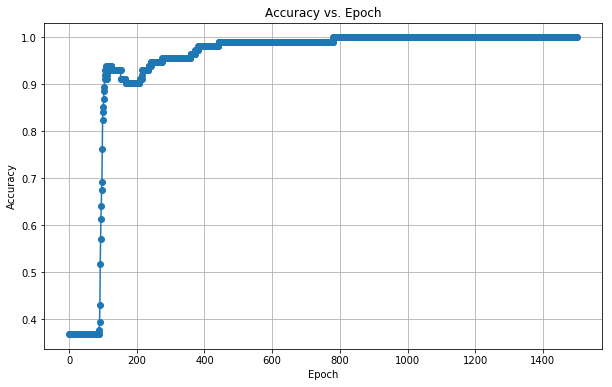

In [252]:
import matplotlib.pyplot as plt

# Plot accuracy for each epoch
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(best_accuracies) + 1), best_accuracies, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Epoch')
plt.grid(True)
plt.show()

In [253]:
criterion = torch.nn.BCELoss(reduction='sum')
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-2)
losses=[]
for epochs in range(600):
    y_pred = model(x_data.float())
    loss = criterion(y_pred, y_data.view(-1,1).float())
#     print('Epoch',epochs,'Loss:',loss.item(), '- Pred:', y_pred.data[0])
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    losses.append(loss)

In [254]:
x_data.data[0]

tensor([-1.4203, -0.8032, -1.3256, -1.1321, -0.1224,  0.3720,  0.0223, -0.6776,
        -1.8175,  1.2368, -0.3793, -0.4442,  0.1365, -0.5582,  3.6717,  2.3118,
         1.7789,  1.6814,  0.3369,  0.5855, -1.3880, -1.3840, -1.2818, -1.0682,
        -0.6296, -0.4150, -0.5492, -1.1775, -2.0397, -0.3665],
       dtype=torch.float64)

In [255]:
model.double().forward(x_data.data[25]) > 0.5, y_data[25]

(tensor([1], dtype=torch.uint8), tensor([1]))

In [256]:
model.double().forward(x_data.data[55]) > 0.5, y_data[55]

(tensor([0], dtype=torch.uint8), tensor([0]))

In [257]:
pred = model.double().forward(x_data) > 0.5
pred.numpy()[:5]

array([[0],
       [0],
       [0],
       [0],
       [0]], dtype=uint8)

In [258]:
a = pred.numpy()
b = y_data.numpy()
pred.numpy().reshape(-1).shape, y_data.numpy().shape


((341,), (341, 1))

In [259]:
y_test.shape

(114, 1)

## Score Metrics Report

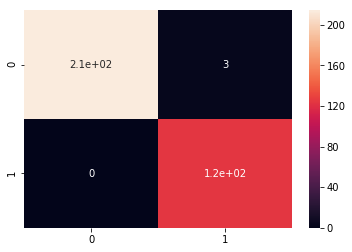

In [260]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
c = confusion_matrix(a,b)
sns.heatmap(c, annot=True, xticklabels=le.classes_, yticklabels=le.classes_);

In [261]:
print(classification_report(a,b))

              precision    recall  f1-score   support

           0       1.00      0.99      0.99       217
           1       0.98      1.00      0.99       124

   micro avg       0.99      0.99      0.99       341
   macro avg       0.99      0.99      0.99       341
weighted avg       0.99      0.99      0.99       341



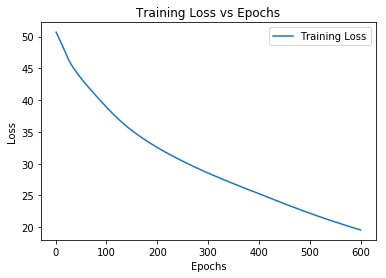

In [262]:
plt.plot(range(1, 600 + 1), losses, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss vs Epochs')
plt.legend()
plt.show()

In [263]:
from sklearn.metrics import accuracy_score

X_test = torch.from_numpy(np.array(X_test))
y_test = torch.from_numpy(np.array(y_test))

threshold = 0.5

y_pred_test = model.double().forward(X_test).detach().numpy()
y_pred_test = [0 if pred < threshold else 1 for pred in y_pred_test]
y_pred_test=torch.from_numpy(np.array(y_pred_test))

# print(y_test)
# print(y_pred_test)
# print(type(y_test))
# print(type(y_pred_test))
accuracy = accuracy_score(y_test, y_pred_test)
print("Accuracy:", accuracy)

Accuracy: 0.9736842105263158


Shape of FPR: (10,)
Shape of TPR: (10,)
Shape of thresholds_roc: (10,)


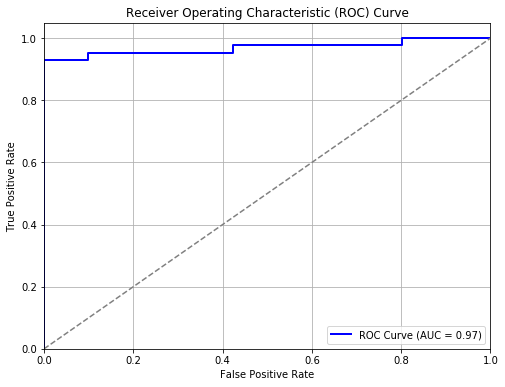

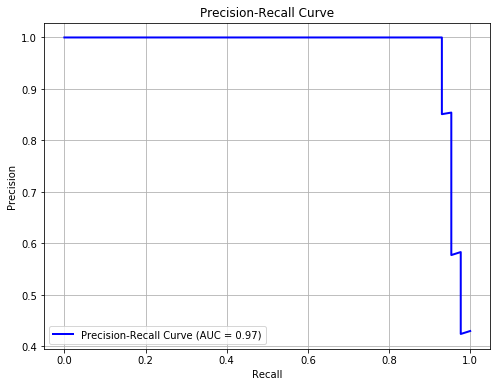

------
Range of predicted probabilities:
Min: 0.014487749756500367
Max: 0.9508289492685463

Range of true labels:
Min: 0
Max: 1
Precision: (101,)
Recall: (101,)
FPR: (10,)
TPR: (10,)


In [264]:
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, auc

# Make predictions
with torch.no_grad():
    pred_test = model.double().forward(X_test).detach().numpy()

# Compute ROC curve and ROC area
fpr, tpr, thresholds_roc = roc_curve(y_test.numpy(), pred_test)

# Ensure FPR and TPR have the same shape as thresholds
print("Shape of FPR:", fpr.shape)
print("Shape of TPR:", tpr.shape)
print("Shape of thresholds_roc:", thresholds_roc.shape)

roc_auc = auc(fpr, tpr)

# Compute precision-recall curve and area under the curve
precision, recall, _ = precision_recall_curve(y_test.numpy(), pred_test)
pr_auc = auc(recall, precision)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Plot Precision-Recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='blue', lw=2, label=f'Precision-Recall Curve (AUC = {pr_auc:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.grid(True)
plt.show()

print("------")
print("Range of predicted probabilities:")
print("Min:", np.min(pred_test))
print("Max:", np.max(pred_test))
print("\nRange of true labels:")
print("Min:", np.min(y_test.numpy()))
print("Max:", np.max(y_test.numpy()))
print("Precision:", precision.shape)
print("Recall:", recall.shape)
print("FPR:", fpr.shape)
print("TPR:", tpr.shape)
# print("\nRange of F1 scores:")
# print("Min:", np.min(f1_scores))
# print("Max:", np.max(f1_scores))


/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-sco

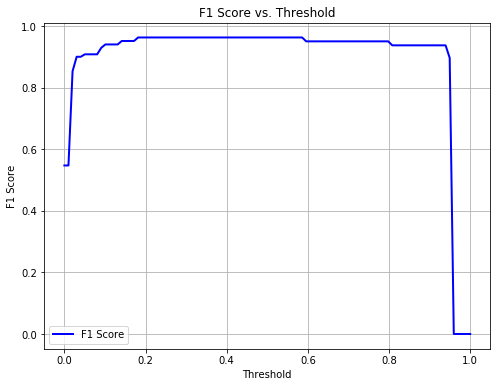

In [265]:
from sklearn.metrics import f1_score
import torch
import numpy as np
import matplotlib.pyplot as plt

# Assuming y_data and pred are PyTorch tensors
# Convert tensors to numpy arrays
# y_data_np = y_data.numpy()

# Compute F1 score for different threshold values
thresholds = np.linspace(0, 1, 100)
f1_scores = [f1_score(y_test.numpy(), (pred_test >= threshold).astype(int)) for threshold in thresholds]

# Plot F1 score with respect to different threshold values
plt.figure(figsize=(8, 6))
plt.plot(thresholds, f1_scores, color='blue', lw=2, label='F1 Score')
plt.xlabel('Threshold')
plt.ylabel('F1 Score')
plt.title('F1 Score vs. Threshold')
plt.grid(True)
plt.legend()
plt.show()
